Need to find an area covered by roughly 4 undithered FOVs for a full PhoSim simulation.

Want the area to have pixels with mean/typical depth= median survey depth. and not so scattered abs(max-min)depth.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import lsst.sims.maf.metricBundles as metricBundles
from findDC1Regions import findDC1Regions

In [2]:
workDir= os.getcwd()

In [3]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_SequentialHexDitherPerNight.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for SequentialHexDitherPerNight:  coaddM5Data_masked_r_SequentialHexDitherPerNight.npz



In [4]:
help(findDC1Regions)

Help on function findDC1Regions in module findDC1Regions:

findDC1Regions(coaddBundle, dbpath, plotTestPlots=True, filterBand='i', threshold=0.0001, nside=256, returnAll=False)
    Find candidate regions for DC1 (based on how wildly the average depth in the region 
    differs from the survey median depth).
    
    Returns a bunch of stuff ...
    
    Required Parameters
    -------------------
      * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to corresponding
                           to a metricBundle object.
           NOTE: coaddBundle should have always have NoDither. If want to find regions based on a dithered
                 survey, the bundle should have the dithered data ALONG WITH the undithered one.
      * dbpath: str: path to the OpSim database.
    
    Optional Parameters
    -------------------
      * plotTestPlots: bool: set to False if dont want to plot things for debugging/testing code.
                             Default: True


#############################################
## Getting RA, Dec for HEALPix pixels ...

#############################################
## Getting simdata ...

#############################################
## Getting pixels_in_FOV ...
Number of fieldIDs in pixel_in_FOV for SequentialHexDitherPerNight: 2249.000000

#############################################
## Code test: Plotting using plotFOV ...


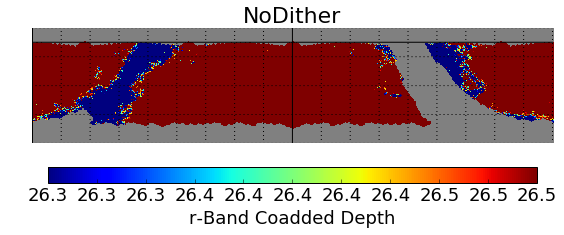

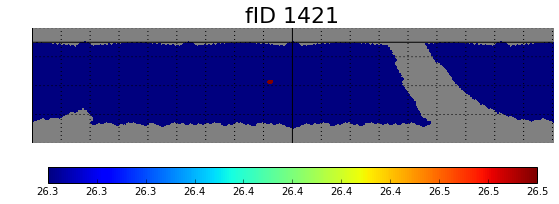

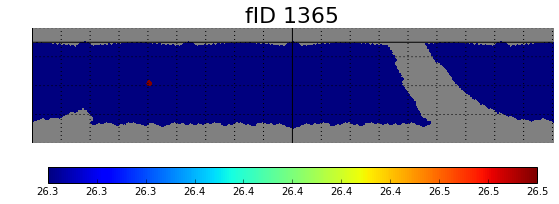

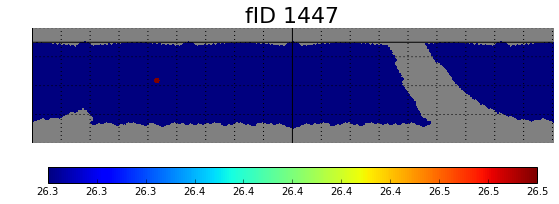

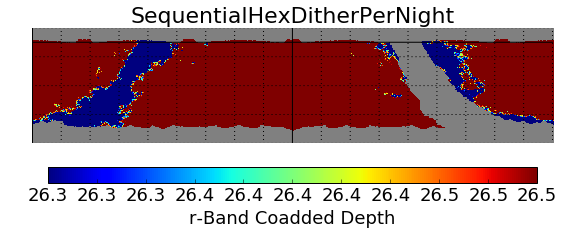

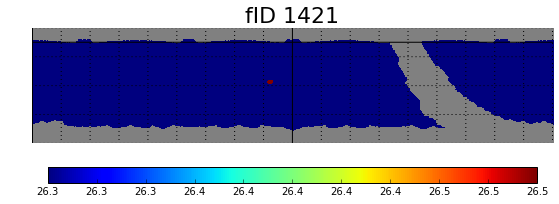

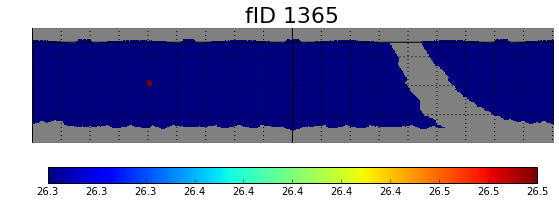

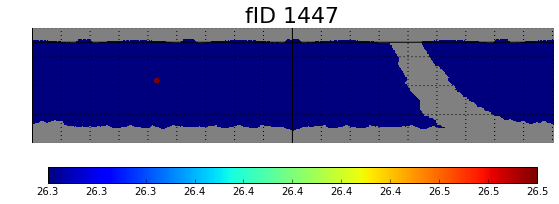


#############################################
## Code test: Plotting regions using buildAndPlotRegion ...
#
## Code test: buildAndPlotRegion: Plots with a RECTANGULAR region of interest ...
FID List for NoDither: [1267, 1279, 1299, 1307, 1387, 1397, 1421, 1429, 1494, 1514, 1524, 1544]
#
## Grey (masked) pixel was inputted in the query_ function.


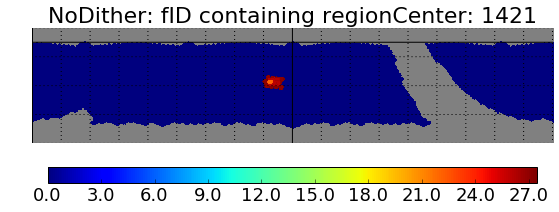

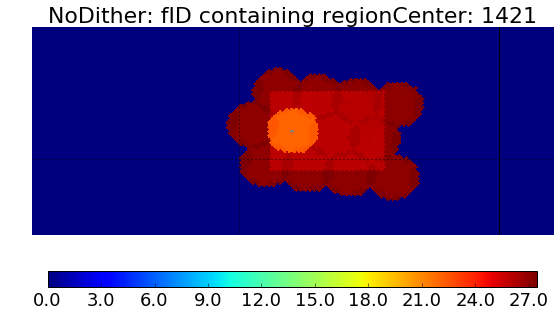

FID List for SequentialHexDitherPerNight: [1267, 1279, 1299, 1307, 1387, 1397, 1421, 1429, 1494, 1514, 1524, 1544]
#
## Grey (masked) pixel was inputted in the query_ function.


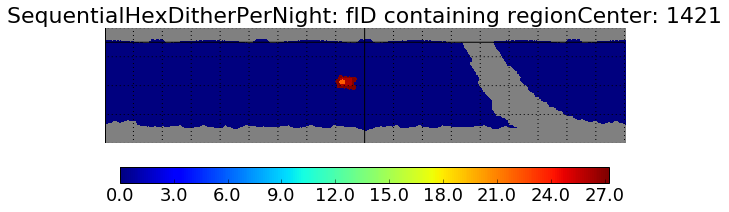

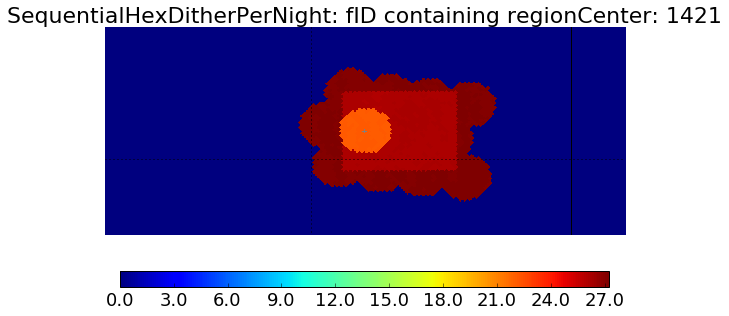

#
## Code test: buildAndPlotRegion: Plots with a CIRCULAR region of interest ...
FID List for NoDither: [1182, 1196, 1216, 1279, 1299, 1307, 1329, 1387, 1397, 1421, 1429, 1451, 1514, 1524, 1544]
#
## Grey (masked) pixel was inputted in the query_ function.


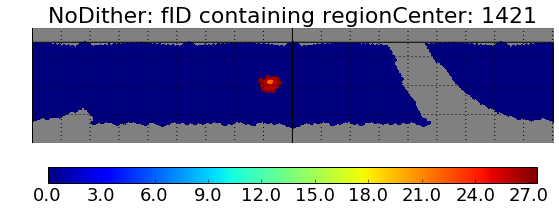

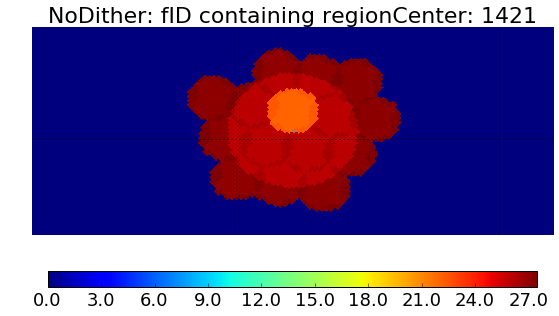

FID List for SequentialHexDitherPerNight: [1182, 1196, 1216, 1279, 1299, 1307, 1329, 1387, 1397, 1421, 1429, 1451, 1514, 1524, 1544]
#
## Grey (masked) pixel was inputted in the query_ function.


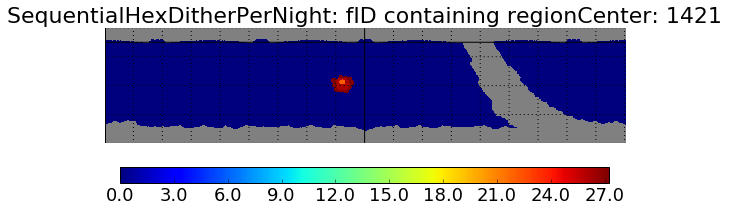

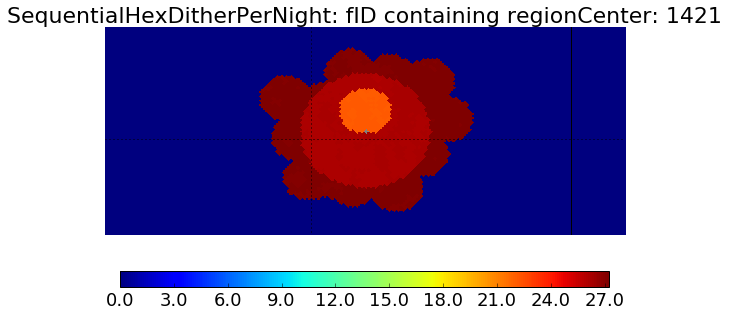


#############################################
## Finding good regions ...
#
## Mean survey depth for SequentialHexDitherPerNight: 27.008246

#############################################
## Finding good regions with threshold= 0.000100 using SequentialHexDitherPerNight

#############################################
## Plotting good regions with threshold= 0.000100 using SequentialHexDitherPerNight
#
## Rectangular regions (using plotRegion):


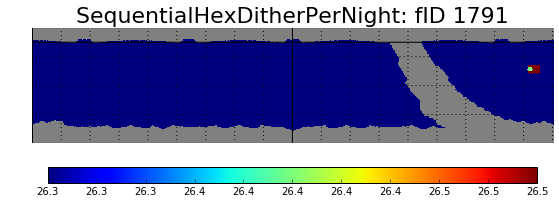

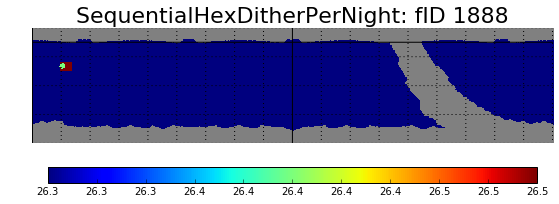

#
## Cicular regions (using plotRegion):


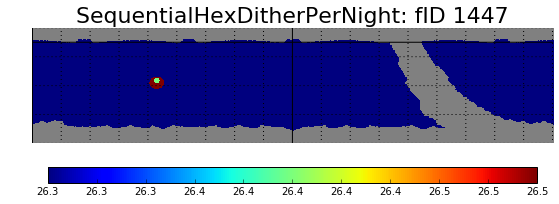

Time taken (s): 537.187216997


In [5]:
startTime= time.time()
dbpath = path+'minion_1016_sqlite.db'
output= findDC1Regions(coaddBundle, dbpath, plotTestPlots= True,
                       filterBand= 'r', returnAll= True)

focusDither, output_rect, output_disc, simdata, pixels_in_FOV, simdataIndex_for_pixel, pixelNum, pixRA, pixDec= output

print 'Time taken (s):', time.time()-startTime

In [6]:
pd.DataFrame(output_rect[1:], ['ID', 'DiffMeanMedian', 'DepthScatter', 'centerRA' , 'centerDec'])

,0,1
ID,1.791000e+03,1888.000000
DiffMeanMedian,6.268360e-07,0.000032
DepthScatter,4.555302e-01,0.364538
centerRA,3.423892e+00,2.778955
centerDec,-3.314060e-01,-0.295396


^^ So we have 2 rectangular regions with the average depth within 0.0001 of the median survey depth.

In [7]:
pd.DataFrame(output_disc[1:], ['ID', 'DiffMeanMedian', 'DepthScatter', 'centerRA' , 'centerDec'])

,0
ID,1447.000000
DiffMeanMedian,0.000085
DepthScatter,0.403503
centerRA,1.641324
centerDec,-0.496321


^^ So we have only 1 circular region with the average depth within 0.0001 of the median survey depth.

### Check some things with the disc region.

In [8]:
os.chdir(workDir)
from intermediates import findRegionFOVs

In [9]:
help(findRegionFOVs)

Help on function findRegionFOVs in module intermediates:

findRegionFOVs(regionPixels, dither, simdataIndex_for_pixel, simdata)
    Find the FOVs that corresponds to any HEALPix pixels in the region.
    
    Required Parameters
    -------------------
      * regionPixels: array: array containing the HEALPIx pixel numbers in the region of interest.
      * dither: str: dither strategy to focus on.
      * simdataIndex_for_pixel: dict: dictionary with keys= dither strategy. Each key points to a dictionary
                                      with keys= pixel number, pointing to the list of indices corresponding
                                      to that pixel in simdata array.
      * simdata: np.array: array containing OpSim columns (must have fieldID for here).



In [10]:
findRegionFOVs(output_disc[0][0], 'NoDither', simdataIndex_for_pixel, simdata)

array([1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464,
       1506, 1542, 1564, 1568])

In [11]:
from plotFunctions import buildAndPlotRegion

In [12]:
help(buildAndPlotRegion)

Help on function buildAndPlotRegion in module plotFunctions:

buildAndPlotRegion(fID, simdata, coaddBundle, FOV_radius, pixels_in_FOV, simdataIndex_for_pixel, nside=256, disc=False)
    Find the region (disc or rectangular) based on the specified field ID and plot it (full survey
    region and a zoomed in version).
    
    Required Parameters
    -------------------
      * fID: int: fieldID for the FOV on which to base the region.
      * simdata: np.array: array containing OpSim columns (must have fieldID, fieldRA, fieldDec).
      * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to corresponding
                           to a metricBundle object.
      * FOV_radius: float: radius of the FOV in radians.
    
    Optional Parameters
    -------------------
      * nside: int: HEALPix resolution parameter. Defaut: 256
      * disc: bool: set to True if want disc-like region; False for rectangular. Default: False
      * FOVBasedPlot: bool: set to True if

FID List for NoDither: [1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464, 1506, 1542, 1564, 1568]
#
## Grey (masked) pixel was inputted in the query_ function.


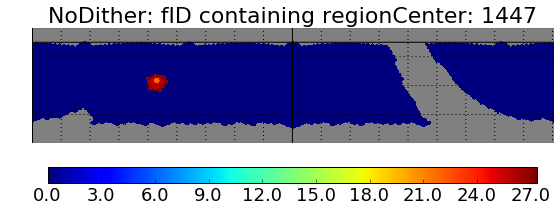

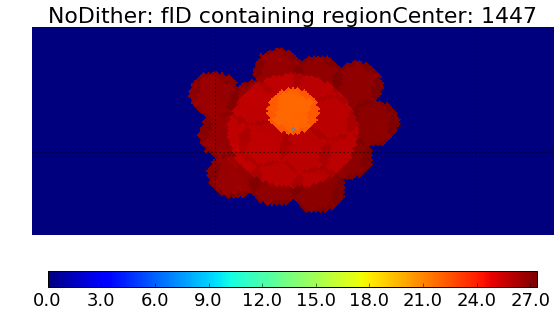

FID List for SequentialHexDitherPerNight: [1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464, 1506, 1542, 1564, 1568]
#
## Grey (masked) pixel was inputted in the query_ function.


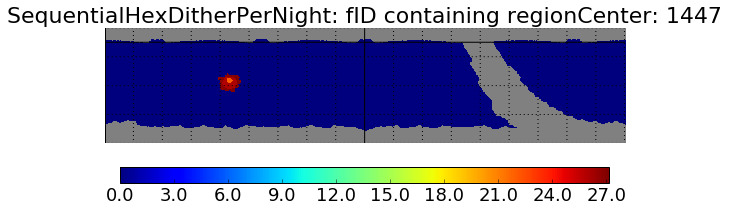

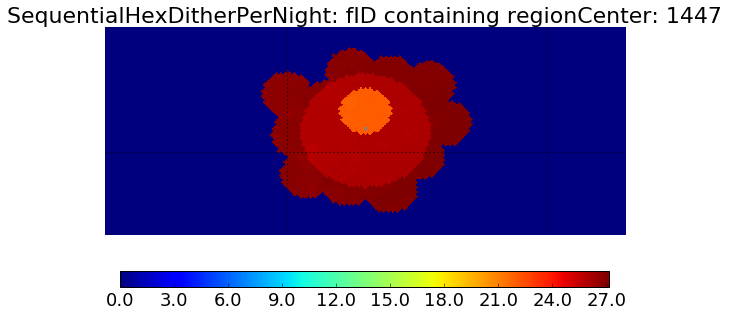

In [13]:
buildAndPlotRegion(output_disc[1][0], simdata, coaddBundle, FOV_radius= 0.0305, 
                   pixels_in_FOV= pixels_in_FOV, 
                   simdataIndex_for_pixel= simdataIndex_for_pixel, disc= True )

### Find the chips in the disc region.

In [14]:
from findDC1Chips import findDC1Chips

startTime= time.time()
regionPixels= output_disc[0][0]
regionChips= findDC1Chips(focusDither, regionPixels, simdataIndex_for_pixel, pixelNum, pixRA, pixDec, simdata)

print 'Time taken (s):', time.time()-startTime

/Users/Humna/lsst/DarwinX86/sims_utils/12.0-13-g6534730/python/lsst/sims/utils/ModifiedJulianDate.py:188: UTCtoUT1Warning: UTC is outside of IERS table for UT1-UTC.
Returning UT1 = UTC for lack of a better idea
This warning was caused by calling ModifiedJulianDate.dut1

  category=UTCtoUT1Warning)
/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We will return only one of the chip names.  If you want both, try re-running with the kwarg allow_multiple_chips=True.
Offending chip names were ['R:4,0 S:0,2,A', 'R:4,0 S:0,2,B']
Offending pupil coordinate point was 0.019187355886 -0.020523287685

  category=MultipleChipWarning)
/Users/Humna/lsst/DarwinX86/sims_coordUtils/12.0-4-g7de6cfa+29/python/lsst/sims/coordUtils/CameraUtils.py:325: MultipleChipWarning: An object has landed on multiple chips.  You asked for this not to happen.
We wil

Time taken (s): 10472.000628


In [15]:
print len(regionChips)

206


In [16]:
regionChips

array([None, 'R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,0 S:2,2,A',
       'R:0,0 S:2,2,B', 'R:0,1 S:0,0', 'R:0,1 S:0,1', 'R:0,1 S:0,2',
       'R:0,1 S:1,0', 'R:0,1 S:1,1', 'R:0,1 S:1,2', 'R:0,1 S:2,0',
       'R:0,1 S:2,1', 'R:0,1 S:2,2', 'R:0,2 S:0,0', 'R:0,2 S:0,1',
       'R:0,2 S:0,2', 'R:0,2 S:1,0', 'R:0,2 S:1,1', 'R:0,2 S:1,2',
       'R:0,2 S:2,0', 'R:0,2 S:2,1', 'R:0,2 S:2,2', 'R:0,3 S:0,0',
       'R:0,3 S:0,1', 'R:0,3 S:0,2', 'R:0,3 S:1,0', 'R:0,3 S:1,1',
       'R:0,3 S:1,2', 'R:0,3 S:2,0', 'R:0,3 S:2,1', 'R:0,3 S:2,2',
       'R:0,4 S:1,0', 'R:0,4 S:2,0,A', 'R:0,4 S:2,0,B', 'R:0,4 S:2,1',
       'R:1,0 S:0,0', 'R:1,0 S:0,1', 'R:1,0 S:0,2', 'R:1,0 S:1,0',
       'R:1,0 S:1,1', 'R:1,0 S:1,2', 'R:1,0 S:2,0', 'R:1,0 S:2,1',
       'R:1,0 S:2,2', 'R:1,1 S:0,0', 'R:1,1 S:0,1', 'R:1,1 S:0,2',
       'R:1,1 S:1,0', 'R:1,1 S:1,1', 'R:1,1 S:1,2', 'R:1,1 S:2,0',
       'R:1,1 S:2,1', 'R:1,1 S:2,2', 'R:1,2 S:0,0', 'R:1,2 S:0,1',
       'R:1,2 S:0,2', 'R:1,2 S:1,0', 'R:1,2 S:1,1', 'R:1,2 S:1,